Предстоит проанализировать набор данных [Weather in Szeged 2006-2016](https://www.kaggle.com/budincsevity/szeged-weather), содержащий информацию о погоде. В качестве зависимой переменной возьмём температуру воздуха в градусах Цельсия (`Temperature (C)`).

Цель состоит в том, чтобы построить две линейные регрессионные модели: **объясняющую** и **предиктивную**. 

- **Объясняющая** модель должна быть пригодна для статистической интерпретации зависимостей, то есть показывать, какие факторы влияют на температуру воздуха, каким образом и какое возможное объяснение этого влияния можно привести.
- **Предиктивная** модель может быть совершенно ужасной с точки зрения статистики (например, все коэффициенты могут быть не значимы), но она должна давать хорошие прогнозы в соответствии с некоторой метрикой.

Хотя приведённые данные имеют формат временных рядов, будем игнорировать это и рассматривать их как обычные кросс-секционные данные (то есть как независимые наблюдения в пространстве).

### Часть 1: Предобработка данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Загружаем данные из файла `weatherHistory.csv`. Выведем первые 5 строк таблицы.

In [ ]:
df = pd.read_csv("weatherHistory.csv")
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Изучаем статью о том, что такое [apparent temperature](https://www.kxan.com/weather/difference-between-temperature-and-feels-like-temperature/) (также называемая "feels-like temperature" и "heat index"). Удалим какую-то переменную из набора данных и поясним, почему мы её удалили (помним о том, какая переменная будет целевой). Также удаляем переменные:
- `Formatted Date` (потому что договорились, что не обращаем внимания на даты).
- `Daily Summary` (будем использовать просто `Summary`). 

In [ ]:
# избавляемся от ненужных колонок
df = df.drop(['Formatted Date','Daily Summary', 'Apparent Temperature (C)'],axis=1)
df.head()

,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,0.0,1015.13
1,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,0.0,1015.63
2,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94
3,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,0.0,1016.41
4,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,0.0,1016.51


Из статьи: “Apparent temperature” is what the temperature feels like when interacting with the human body. This is a result of when relative humidity and air temperature are combined. Поэтому, будет разумно скомбинировать 3 фичи из предложенного датасета и работать по ней.

In [ ]:
df_new = df[['Temperature (C)', 'Humidity']]
df_new.head()

,Temperature (C),Humidity
0,9.472222,0.89
1,9.355556,0.86
2,9.377778,0.89
3,8.288889,0.83
4,8.755556,0.83


In [ ]:
df_new.describe(include='all')

,Temperature (C),Humidity
count,96453.000000,96453.000000
mean,11.932678,0.734899
std,9.551546,0.195473
min,-21.822222,0.000000
25%,4.688889,0.600000
50%,12.000000,0.780000
75%,18.838889,0.890000
max,39.905556,1.000000


Есть ли в наборе данных пропущенные значения? Если да, удалим их.

In [ ]:
### пропущенные значения присутствуют
display(df.isna().sum())
display(df.isna().sum().sum() / (len(df) * len(df.columns)))

Summary                     0
Precip Type               517
Temperature (C)             0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
dtype: int64

0.0005955692870563326

In [ ]:
df.shape

(96453, 9)

In [ ]:
# удаляем все объекты, которые содержат значения NaN
df = df.dropna()

In [ ]:
### теперь пропущенные значения отсутствуют
display(df.isna().sum())
display(df.isna().sum().sum() / (len(df) * len(df.columns)))

Summary                   0
Precip Type               0
Temperature (C)           0
Humidity                  0
Wind Speed (km/h)         0
Wind Bearing (degrees)    0
Visibility (km)           0
Loud Cover                0
Pressure (millibars)      0
dtype: int64

0.0

В данных есть одна числовая переменная, которая не несёт информации для предсказания целевой переменной. Найдём эту переменную, пояснив наш выбор и удалим её. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95936 entries, 0 to 96452
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Summary                 95936 non-null  object 
 1   Precip Type             95936 non-null  object 
 2   Temperature (C)         95936 non-null  float64
 3   Humidity                95936 non-null  float64
 4   Wind Speed (km/h)       95936 non-null  float64
 5   Wind Bearing (degrees)  95936 non-null  float64
 6   Visibility (km)         95936 non-null  float64
 7   Loud Cover              95936 non-null  float64
 8   Pressure (millibars)    95936 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.3+ MB


In [ ]:
df.describe()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.0,95936.000000
mean,11.940976,0.734841,10.804936,187.518773,10.362402,0.0,1003.150038
std,9.570671,0.195724,6.920727,107.385351,4.173780,0.0,117.276976
min,-21.822222,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.604167,0.600000,5.796000,116.000000,8.372000,0.0,1011.890000
50%,12.033333,0.780000,9.933700,180.000000,10.046400,0.0,1016.420000
75%,18.844444,0.890000,14.135800,290.000000,14.812000,0.0,1021.050000
max,39.905556,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


Мы не очень заинтересованы в переменной 'Loud Cover', поскольку, ссылаясь на ячейку выше, все переменные имеют значение 0.0 и она не меняется => избавимся от этой переменной

In [ ]:
df = df.drop(['Loud Cover'], axis=1)

Построим диаграммы рассеяния всех числовых переменных против целевой (для этого воспользуемся каким-то методом из `seaborn`). Есть ли переменные, для которых наблюдается очевидная нелинейная зависимость?

In [ ]:
num_col = ["Temperature (C)","Humidity","Wind Speed (km/h)","Wind Bearing (degrees)","Visibility (km)","Pressure (millibars)"]

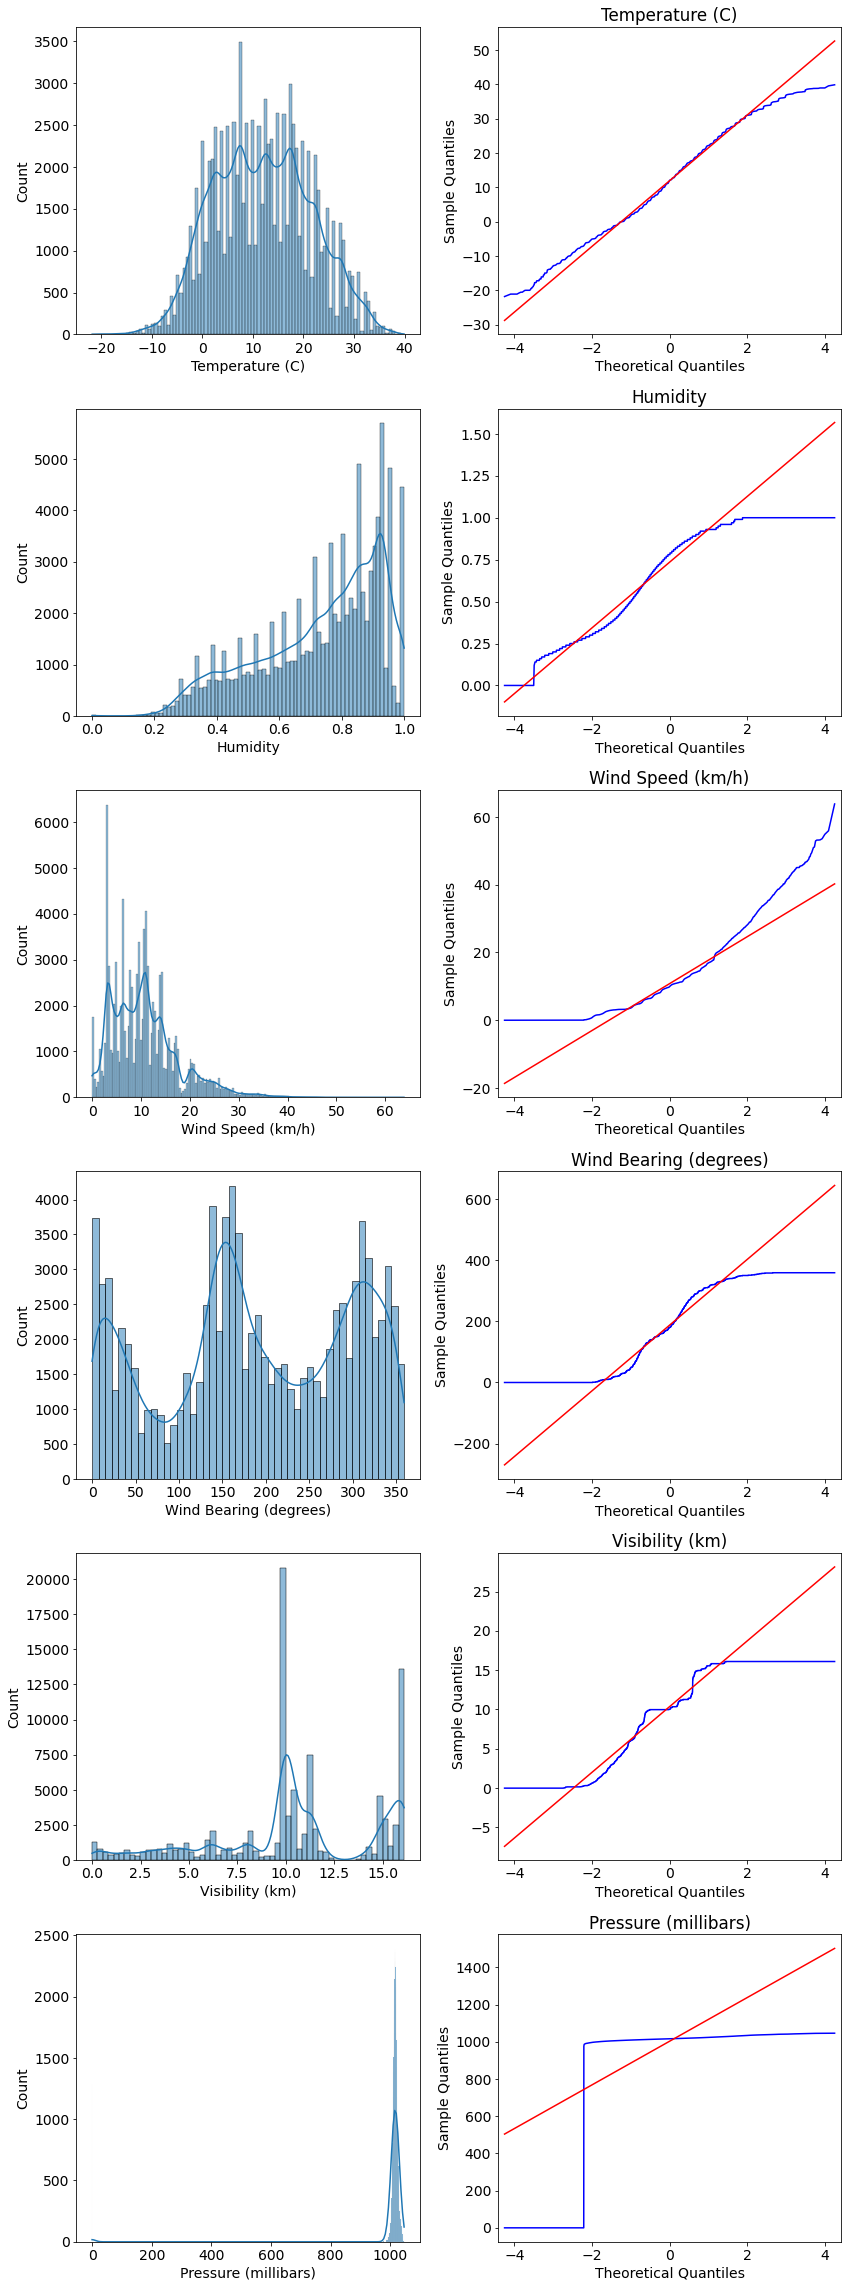

In [ ]:
import statsmodels.api as sm

fig,axes = plt.subplots(len(num_col),2,figsize=(12, len(df.columns)*4))
for i, col in enumerate(num_col):
    sns.histplot(df[col], ax = axes[i,0],kde =True)
    sm.qqplot(df[col].dropna(),line = "s",fmt = "b",ax = axes[i,1])
    axes[i, 1].set_title(col)

plt.tight_layout()
plt.show()

Как можно заметить, некоторые графики имеют большое отклонение от желаемого распределения и явно не имеют линейной зависимости. Как один из вариантов - можно применить логарифмического преобразования к искаженным объектам таким как: 'Pressure (millibars)' и 'Visibility (km)'

Преобразуем категориальные переменные при помощи One Hot Encoding (то есть переведём их в дамми-переменные).

In [ ]:
#label encoding 'Precip Type' column
#print(df['Precip Type'].value_counts())
#df['Precip Type'] = df['Precip Type'].replace(['rain','snow'], [0, 1])
#print(df['Precip Type'].value_counts())

In [ ]:
#label encoding 'Summary' column
#print(df['Summary'].value_counts())
#df['Summary'] = df['Summary'].replace(df['Summary'].unique(),range(0, len(df['Summary'].unique())))
#print(df['Summary'].value_counts())

In [ ]:
df = pd.get_dummies(df)

In [ ]:
df.head(8)

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary_Breezy,Summary_Breezy and Dry,Summary_Breezy and Foggy,Summary_Breezy and Mostly Cloudy,...,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,Precip Type_rain,Precip Type_snow
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,9.222222,0.85,13.9587,258.0,14.9569,1016.66,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
6,7.733333,0.95,12.3648,259.0,9.9820,1016.72,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
7,8.772222,0.89,14.1519,260.0,9.9820,1016.84,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


Выведем корреляционную матрицу переменных. Какие переменные лучше всего коррелируют с целевой (назовите три)? 

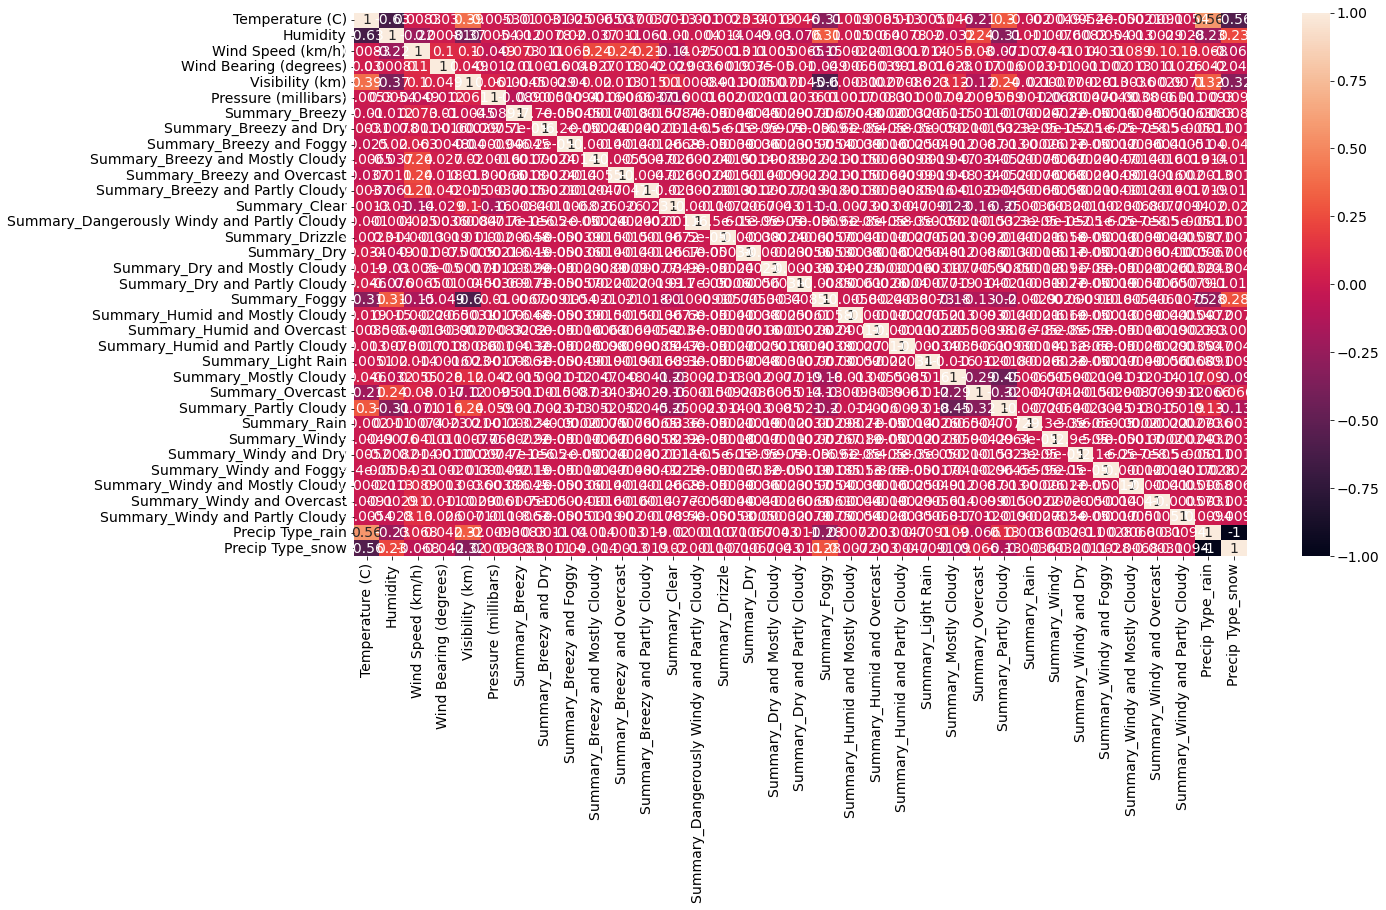

In [ ]:
plt.figure(figsize = (20, 10))
sns.heatmap(df.corr(), annot=True);

In [ ]:
corr_matrix = df.corr()
corr_matrix["Temperature (C)"].sort_values(ascending=False)

Temperature (C)                                1.000000
Precip Type_rain                               0.563503
Visibility (km)                                0.393719
Summary_Partly Cloudy                          0.300242
Summary_Mostly Cloudy                          0.046225
Summary_Dry and Partly Cloudy                  0.045897
Summary_Dry                                    0.033726
Wind Bearing (degrees)                         0.029937
Summary_Humid and Mostly Cloudy                0.019089
Summary_Dry and Mostly Cloudy                  0.018805
Summary_Humid and Partly Cloudy                0.013392
Summary_Humid and Overcast                     0.008545
Wind Speed (km/h)                              0.008304
Summary_Windy and Dry                          0.005155
Summary_Breezy and Partly Cloudy               0.003664
Summary_Breezy and Dry                         0.003093
Summary_Clear                                  0.001308
Summary_Windy and Foggy                       -0

In [ ]:
# возьмем по модулю, чтобы найти более значимые корреляццции
np.abs(df.corr()[['Temperature (C)']]).sort_values(by='Temperature (C)', ascending=False)

,Temperature (C)
Temperature (C),1.000000
Humidity,0.632148
Precip Type_snow,0.563503
Precip Type_rain,0.563503
Visibility (km),0.393719
Summary_Foggy,0.310437
Summary_Partly Cloudy,0.300242
Summary_Overcast,0.211532
Summary_Mostly Cloudy,0.046225
Summary_Dry and Partly Cloudy,0.045897


В большей степени с целевой переменной коррелируют признаки: Humidity, Precip Type (snow или rain - без разницы, влияние одинаковое) и Visibility (km).

Разделим данные на регрессоры (`X`) и целевую переменную (`y`). Если всё сделано правильно, то `X` и `y` должны иметь размеры, указанные ниже.

In [ ]:
#target = y = df["Temperature (C)"]
#regressor = X = df.drop(['Temperature (C)'], axis=1)
regressors = X = df[df.columns[1:]]
target = y = df['Temperature (C)']

In [ ]:
print('X:', X.shape)
print('y:', y.shape)
# размеры одинаковые

X: (95936, 34)
y: (95936,)


Похоже ли распределение целевой переменной на нормальное? Поясним, почему важно, чтобы распределение `y` было похоже на нормальное.

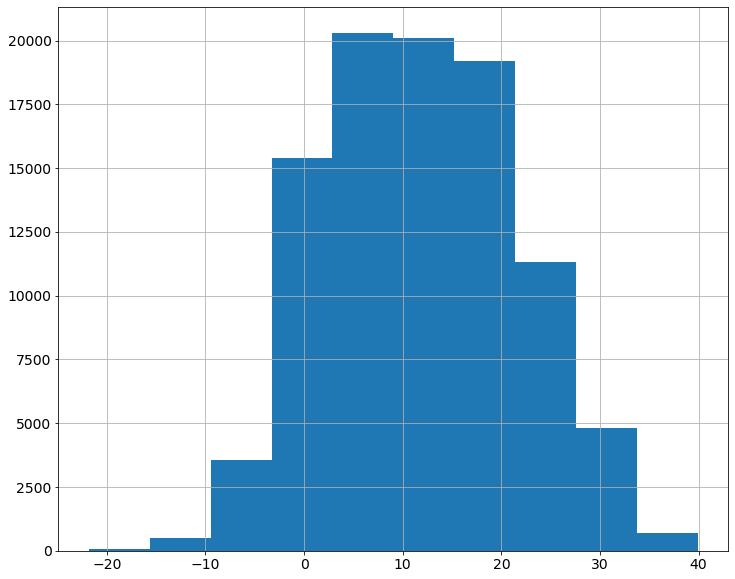

In [ ]:
df["Temperature (C)"].hist()

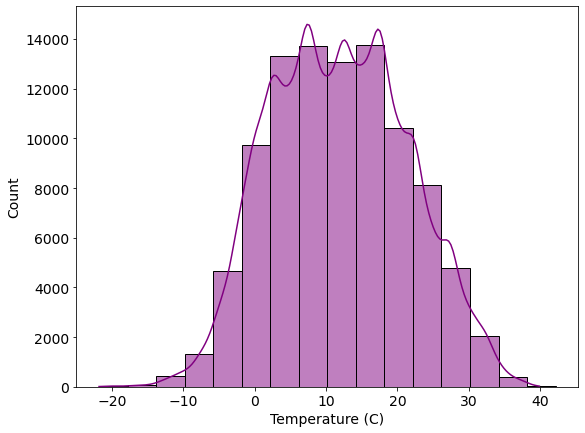

In [ ]:
fig, ax = plt.subplots(figsize = (9, 7))
sns.histplot(y, ax = ax, binwidth=4, color = "purple", kde = True)

И правда, распределение целевой переменной относительно похоже на нормальное. На самом деле нормальное распределение очень важно, так как многие ML методы работают намного лучше (метрика будет расти), если данные нормально распределены (или вообще не работают в противном случае).

### Часть 2: Построение объясняющей модели

На основании предыдущего анализа и логических соображений выберите шесть регрессоров (не считая константный), которые будут включены в объясняющую модель. Помним, что когда мы строим объясняющую модель, выбор переменных должнен быть обоснован (не достаточно использовать предыдущий анализ, выбор каждой переменной должен иметь теоретическое или логическое обоснование). В качестве регрессоров можно брать переменные из `X` или преобразования над ними (`Humidity` и `Humidity`$^2$ будем считать разными регрессорами). 

Создадим ячейку Markdown ниже и запишем в неё функциональный вид модели, которую мы будем оценивать. Поясним выбор регрессоров (не нужно углубляться в физику поведения жидкостей и ссылаться на уравнения Навье-Стокса, достаточно понятной научно-популярной интерпретации) и, если использум, выбор нелинейных преобразований над ними.

**Ответ:**

$$
y_i = \beta_0 + \beta_1 * Humidity + \beta_2 * Humidity^2 + \beta_3 * Precip Type_{Rain} + \beta_4 * Visibility + \beta_5 * Visibility^2 + \beta_6 * WindSpeed^2 + \varepsilon_i
$$

Обоснование выбора переменных:
- $Humidity$ –  имея постоянный объём влаги в воздухе, увеличение температуры послужит увеличению максимального объёма влаги в воздухе, значит, относительная влажность снизится.
- $Humidity^2$ – ввиду того, что очень высокий уровень влажности, обычно такое происходит в горах. А значит воздушные массы не смогут правильно покинуть эту местность, что удерживает высокую/низкую температуру воздуха в данном месте.
- $PrecipType_{Rain}$ – логично, что дождь подразумевает, что температура воздуха низкая.
- $WindSpeed^2$ – места с высоким уровнем ветра имеют такую тенденцию, что в них нагретый воздух быстро улетает. Скорость ветра возведена в квадрат в случае когда ветер в данной местности гораздо быстрее, чем в ближайших.
- $Visibility$ – логично, что видимость местности напрямую связана с временем дня, также это связано с выходом солнца из-за горизонта, и дополнительным нагревом земли и воздуха.
- $Visibility^2$ – стоит возвести в квадрат для большего эффекта значимости, имея низкую видимость в данной местности, это послужит тому, что на улице ночь, а ночью температура как принято ниже.

Выделим выбранные признаки в переменную `X1`. 

In [ ]:
#X1 = pd.DataFrame(np.c_[df["Humidity"], df["Visibility (km)"], df["Precip Type_snow"]], 
                  #columns = ["Humidity", "Visibility (km)", "Precip Type_snow"])
X1 = df[['Humidity', 'Precip Type_rain', 'Visibility (km)']].copy(deep=True)
X1['Humidity^2'] = np.power(X1['Humidity'], 2)
X1['Visibility^2'] = np.power(X1['Visibility (km)'], 2)
X1['WindSpeed^2'] = np.power(df['Wind Speed (km/h)'], 2)
#X1 = pd.DataFrame(np.c_[df["Wind Bearing (degrees)"], df["Visibility (km)"], df["Pressure (millibars)"]], 
                  #columns = ["Wind Bearing (degrees)", "Visibility (km)", "Pressure (millibars)"])
y = df["Temperature (C)"]
X1

,Humidity,Precip Type_rain,Visibility (km),Humidity^2,Visibility^2,WindSpeed^2
0,0.89,1,15.8263,0.7921,250.471772,199.365928
1,0.86,1,15.8263,0.7396,250.471772,203.478813
2,0.89,1,14.9569,0.7921,223.708858,15.432327
3,0.83,1,15.8263,0.6889,250.471772,198.911533
4,0.83,1,15.8263,0.6889,250.471772,121.983189
...,...,...,...,...,...,...
96448,0.43,1,16.1000,0.1849,259.210000,120.918614
96449,0.48,1,15.5526,0.2304,241.883367,101.902968
96450,0.56,1,16.1000,0.3136,259.210000,80.708662
96451,0.60,1,16.1000,0.3600,259.210000,110.868264


Оценим модель при помощи МНК (минимзации MSE). Прокомментируем значимость коэффициентов.

In [ ]:
mdl = sm.OLS(y, sm.add_constant(X1))
reslt = mdl.fit()
print(reslt.summary())

                            OLS Regression Results                            
Dep. Variable:        Temperature (C)   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                 2.600e+04
Date:                Thu, 09 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:34:00   Log-Likelihood:            -3.0650e+05
No. Observations:               95936   AIC:                         6.130e+05
Df Residuals:                   95929   BIC:                         6.131e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               27.3712      0.223  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Допустим, уровень значимости у нас 5%, и нам необходимо, чтобы |t| > 1.95, а в нашем случае неравенство выполняется для всех коэффициентов нашей модели, что говорит о том, что все коэффициенты у нас значимы.

Поясним, как каждый регрессор влияет на зависимую переменную 
1. математически ("при увеличении $X$ на 1 $Y$ увеличивается на 3") и 
2. содержательно ("$X$ влияет на $Y$ положительно, потому что...", "$X$ не оказывает влияния на $Y$).

1) **Humidity**: при увеличении относительной влажности воздуха на 1% - температура воздуза уменьшается на 0.66°C. Видим, что данный показатель влияет на целевую переменную отрицательно, потому что увеличение температуры повышает объём влаги, содержащийся в воздухе, а значит, при постоянном объёме относительная влажность снижается.

2) **Humidity$^2$**: при увеличении квадрата относительной влажности воздуха на 1% - в квадрате температура воздуха увеличивается на 0.3°C. Квадрат влажности воздуха влияет на целевую переменную положительно, так как высокие уровни влажности характерны для местностей с теплым климатом, нежели чем холодным.

3) $PrecipType_{Rain}$: дождь увлажняет температуру воздуха на 12°C. Данное влияние имеет положительное влияние.

4) **Visibility**: при увеличении видимости на 1 км - температура воздуза увеличивается на 0.7°C. Видимость влияет на целевую переменную положительно, так как чем больше видимость, тем больше шанс, что на улице не ночь, а значит, в среднем температура выше.

5) **Visibility$^2$**: при увеличении квадрата видимости на 1 км$^2$ - температура воздуза уменьшается на 0.02°C. Квадрат видимости влияет на целевую переменную отрицательно, ввиду того, что очень хорошая видимость может быть и при хорошей погоде.

6) **WindSpeed$^2$**: при увеличении квадрата скорости ветра на 1 (км/ч)$^2$ - температура воздуза уменьшается на 0.0058°C, учитывая, что данный показатель ранжируется от 0 до $64^2$. Квадрат скорости ветра влияет на целевую переменную отрицательно влияние, ввиду того, что нагретый воздух мгновенно покидает места с сильным ветром.

Рассчитаем $R^2$ и MSE на выборке `X1`. Прокомментируем качество подгонки регрессии.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# The lower the value, the better the fit
#print("MSE = ", mean_squared_error(y_test, y_pred))

# The closer towards 1, the better the fit
#print("R2 = ", r2_score(y_test, y_pred))
r2_score = round(reslt.rsquared, 2)
print("R2 Linear Regression Score :{:%}".format(r2_score))

R2 Linear Regression Score :62.000000%


### Часть 3: Построение предсказательной модели

В предыдущей части мы хотели объяснить $y$ при помощи каких-то регрессоров, которые мы отбирали из теоретико-логических соображений. Теперь поставим другую задачу: мы не хотим ничего объяснять, а хотим только хорошо предсказывать $y$ по новым наблюдениям. Код ниже поделит выборку (`X`, `y`) на обучающую (`X_train`, `y_train`), на которой будем *оценивать* модель, и *тестовую* (`X_test`, `y_test`), на которой будем предсказывать. 

In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Сохраним в переменные `X_train_1` и `X_test_1` те же признаки из `X_train` и `X_test` соответственно, что и в `X1` (то есть те, которые мы выбрали в ранее).

Оценим модель на выборке `X_train_1`. Сделаем предсказания на выборках `X_train_1` (то есть обучающей) и `X_test_1` (то есть тестовой). Рассчитаем `MAE` на этих выборках.

In [ ]:
np.random.seed(123)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y, test_size = 0.3)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train_1, y_train_1)

In [ ]:
from sklearn.metrics import mean_absolute_error

y_pred_train_1 = model.predict(X_train_1)
y_pred_test_1 = model.predict(X_test_1)
print('MAE - train:', mean_absolute_error(y_train_1, y_pred_train_1))
print('MAE - test:', mean_absolute_error(y_test_1, y_pred_test_1))

MAE - train: 4.8178652649374145
MAE - test: 4.833636538721745


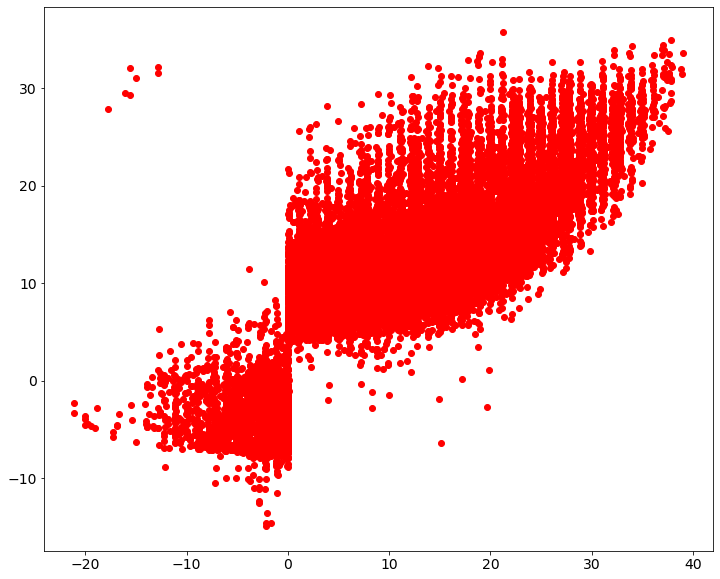

In [ ]:
import matplotlib

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (12, 10)
plt.scatter(y_test_1,y_pred_test_1,c='r');

Теперь сохраним в переменные `X_train_2` и `X_test_2` те же признаки из `X_train` и `X_test` соответственно, что и в `X1` (то есть те, которые вы выбрали в задании 9) и ещё какие-то признаки (количество выберите на ваш вкус, главное, чтобы всего признаков было больше, чем в `X1`). Оценим модель на выборке `X_train_2`. Сделаем предсказания на выборках `X_train_2` (то есть обучающей) и `X_test_2` (то есть тестовой). Рассчитаем `MAE` на этих выборках. Удалось ли повысить качество на обучающей выборке? А на тестовой? 

In [ ]:
X2 = X1.copy(deep=True)

In [ ]:
X2['SummaryPartlyCloudy'] = df['Summary_Partly Cloudy']
X2['SummaryOvercast'] = df['Summary_Overcast']
# воспользуемся попарными произведениями 
X2['Humidity * Pressure'] = df['Humidity'] * df['Pressure (millibars)']
X2['Humidity * WindSpeed'] = df['Humidity'] * df['Wind Speed (km/h)']
X2['Visibility * Pressure'] = df['Visibility (km)'] * df['Pressure (millibars)']

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y, test_size = 0.3)

In [ ]:
model2 = LinearRegression().fit(X_train_2, y_train_2)

In [ ]:
y_pred_train_2 = model2.predict(X_train_2)
y_pred_test_2 = model2.predict(X_test_2)
print('MAE - train:', mean_absolute_error(y_train_2, y_pred_train_2))
print('MAE - test:', mean_absolute_error(y_test_2, y_pred_test_2))

MAE - train: 4.780556904846757
MAE - test: 4.798912314479757


Заметим, что MAE уменьшилось на обеих выборках как на обучающей, так и на тестовой. Это говорит о том, что используя больше признаков для предсказания - качество на обеих выборках увеличивается, что есть хорошо!

Прокомментируем значимость коэффициентов модели, оценённой на `X_train_2`.

In [ ]:
mdl = sm.OLS(y_train_2, sm.add_constant(X_train_2))
reslt = mdl.fit()
print(reslt.summary())

                            OLS Regression Results                            
Dep. Variable:        Temperature (C)   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                 1.016e+04
Date:                Thu, 09 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:34:01   Log-Likelihood:            -2.1399e+05
No. Observations:               67155   AIC:                         4.280e+05
Df Residuals:                   67143   BIC:                         4.281e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    26.23

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Так же как и с предыдущим кейсом, берем в пример уровень значимости 5%, и необходимо, чтобы |t| > 1.95, а в нашем случае неравенство выполняется для всех коэффициентов нашей модели, что говорит о том, что все коэффициенты у нас значимы. А значит, гипотеза о равенстве к нулю отвергается.

Будем называть модель, оценённую на `X_train_1`, **объясняющей**, а на `X_train_2` – **предсказательной**. На основании предыдущих шагов сделайте вывод, подходит ли объясняющая модель для предсказаний. На основании последнего шага сделайте вывод, подходит ли предсказательная модель для объяснительной интерпретации. 

На основании предыдущих шагов: Ссылаясь на качество моделей, можно с уверенностью сказать, что **предсказательная** модель - `X_train_2` ведёт себя лучше как на тестовой, так и на обучающей выборках в сравнении с **объясняющей** моделью - `X_train_1`.

На основании последнего шага: Ввиду того, что в **предсказательной** модели `X_train_2` были использованы некие модернизации признаков, в частности попарные произведения, то их несомненно будет сложно интерпретировать. Использовать данную модель для объяснительной интерпретации не советуется.

## Extra thoughts

Для более понятной интерперетации 'сложных' признаков стоит воспользоваться моделями Explainable AI, такими как LIME, SHAP, ELI5. Благодаря данным моделям интерпретация становится более понятной и объяснимой на простой язык. 